In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    roc_auc_score,
    roc_curve
    )
import joblib

In [2]:
df = pd.read_csv("../Data/processed_data/cleaned_reviews.csv")

In [3]:
print(df.loc[34567:34572])

                                            cleaned_text sentiment
34567  definitely worst columbo ever dreamt murder ab...  negative
34568  title like know expect great horror movie real...  negative
34569  dont spend much time watching made tv movie se...  negative
34570  far richer texture character even classic geor...  positive
34571  film called adventure cinemascope like screenw...  negative
34572  premise movie simple script elderly muslim get...  positive


In [4]:
x = df['cleaned_text']
y = df['sentiment']

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

In [6]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range= (1,2)
)

In [7]:
x_train_tfidf = tfidf.fit_transform(xtrain)
x_test_tfidf = tfidf.transform(xtest)

In [8]:
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(40000, 5000)
(10000, 5000)


In [9]:
lb = LabelEncoder()

In [10]:
y_train_lb = lb.fit_transform(ytrain)
y_test_lb = lb.transform(ytest)

In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial_NB': MultinomialNB(),
    'Linear_SVC': LinearSVC()
}

In [12]:
for model_name, model in models.items():
    print(model_name,":")
    train_model = model.fit(x_train_tfidf, y_train_lb)
    print(f"Train Score: {train_model.score(x_train_tfidf, y_train_lb)}")
    print(f"Test Score: {train_model.score(x_test_tfidf, y_test_lb)}")
    pred = train_model.predict(x_test_tfidf)
    print(f'Confussion Matrix:\n{confusion_matrix(y_test_lb, pred)}')
    print(f'Accuracy score:\n{accuracy_score(y_test_lb, pred)}')
    print("-------------------------")

Logistic Regression :
Train Score: 0.9113
Test Score: 0.8883
Confussion Matrix:
[[4339  622]
 [ 495 4544]]
Accuracy score:
0.8883
-------------------------
Multinomial_NB :
Train Score: 0.866875
Test Score: 0.8557
Confussion Matrix:
[[4176  785]
 [ 658 4381]]
Accuracy score:
0.8557
-------------------------
Linear_SVC :
Train Score: 0.93015
Test Score: 0.8819
Confussion Matrix:
[[4334  627]
 [ 554 4485]]
Accuracy score:
0.8819
-------------------------


Logistic Regression showed the best results compared to other models. Therefore, I've decided to move forward with Logistic Regression for this sentiment analysis task.

In [13]:
logistic = LogisticRegression(max_iter=1000)

In [14]:
logistic_model = logistic.fit(x_train_tfidf, y_train_lb)

In [15]:
print(f"Train Score: {logistic_model.score(x_train_tfidf, y_train_lb)}")
print(f"Test Score: {logistic_model.score(x_test_tfidf, y_test_lb)}")

Train Score: 0.9113
Test Score: 0.8883


In [16]:
logistic_pred = logistic_model.predict(x_test_tfidf)

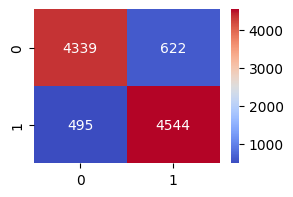

In [17]:
cm_log = confusion_matrix(y_test_lb, logistic_pred)  

plt.figure(figsize=(3, 2))                    
sns.heatmap(cm_log, annot=True, cmap='coolwarm', fmt='g') 
plt.show()  

In [18]:
print(f'Classification Report:\n{classification_report(y_test_lb, logistic_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [19]:
print(f'Accuracy Score:\n{accuracy_score(y_test_lb, logistic_pred)}')

Accuracy Score:
0.8883


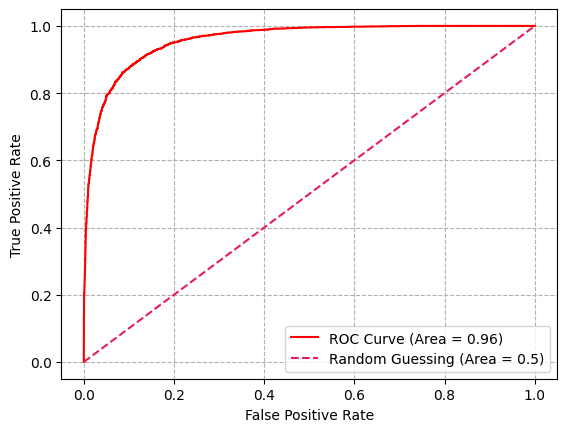

In [20]:
log_pred_proba = logistic_model.predict_proba(x_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test_lb, log_pred_proba)             
roc_auc = roc_auc_score(y_test_lb, log_pred_proba)

plt.plot(fpr, tpr, color='red', label=f'ROC Curve (Area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color="#E41D59", linestyle="--", label='Random Guessing (Area = 0.5)') 

plt.xlabel("False Positive Rate")    
plt.ylabel("True Positive Rate")     
plt.legend(loc='lower right')       
plt.grid(True, linestyle="--")                      
plt.show()    

In [30]:
joblib.dump(logistic_model, "../Models/logistic_model.joblib")

['../Models/logistic_model.joblib']

In [31]:
joblib.dump(tfidf, "../Models/tfidf_vectorizer.joblib")

['../Models/tfidf_vectorizer.joblib']

In [32]:
joblib.dump(lb, "../Models/labeb_encoder.joblib")

['../Models/labeb_encoder.joblib']